In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        file_path = os.path.join(dirname, filename)
        print(file_path)
        
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amazon-top-50-bestselling-books-2009-2019/bestsellers with categories.csv


In [51]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv(file_path)

# Create SQLite in-memory database
conn = sqlite3.connect(':memory:')  # temporary DB
df.to_sql('amazon_books', conn, index=False, if_exists='replace')

550

In [4]:
df.head()

,Name,Author,User Rating,Reviews,Price,Year,Genre
0,10-Day Green Smoothie Cleanse,JJ Smith,4.7,17350,8,2016,Non Fiction
1,11/22/63: A Novel,Stephen King,4.6,2052,22,2011,Fiction
2,12 Rules for Life: An Antidote to Chaos,Jordan B. Peterson,4.7,18979,15,2018,Non Fiction
3,1984 (Signet Classics),George Orwell,4.7,21424,6,2017,Fiction
4,"5,000 Awesome Facts (About Everything!) (Natio...",National Geographic Kids,4.8,7665,12,2019,Non Fiction


## 1. Time Trends & Market Shifts 
* How did average ratings, prices, or genres change from 2009–2019?
* Which genre generates higher average revenue? (using reviews as a proxy of the actual number of sold copies)

In [49]:
# How did average ratings, prices, or genres change from 2009–2019?
query = """
select
    year,
    round(avg("User Rating"),2) as avg_rating,
    round(avg(case when price > 0 then price end),2) as avg_price,
    round(1.0*sum(case when genre = 'Fiction' then 1 else 0 end)/count(*),2) as fiction_rate
from amazon_books
group by year
order by year
"""
df_trend = pd.read_sql_query(query, conn)

pd.read_sql_query(query, conn)

,Year,avg_rating,avg_price,fiction_rate
0,2009,4.58,15.40,0.48
1,2010,4.56,13.76,0.40
2,2011,4.56,15.41,0.42
3,2012,4.53,15.30,0.42
4,2013,4.55,15.21,0.48
5,2014,4.62,15.91,0.58
6,2015,4.65,10.63,0.34
7,2016,4.68,13.73,0.38
8,2017,4.66,11.61,0.48
9,2018,4.67,10.52,0.42


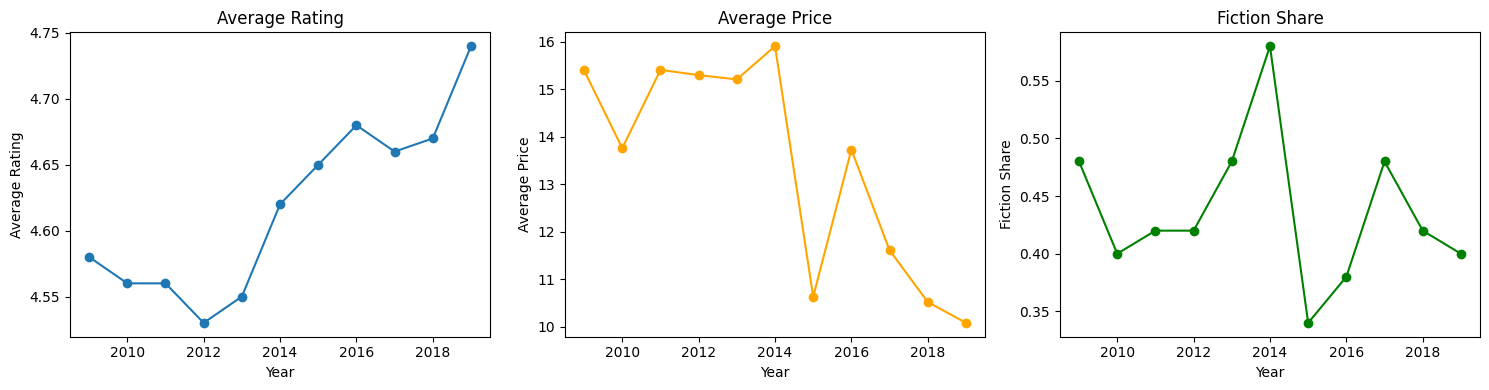

In [59]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))  # smaller height, wider for 3 plots

# Plot 1: Average Rating
axes[0].plot(df_trend['Year'], df_trend['avg_rating'], marker='o')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Average Rating')
axes[0].set_title('Average Rating')

# Plot 2: Average Price
axes[1].plot(df_trend['Year'], df_trend['avg_price'], marker='o', color='orange')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Average Price')
axes[1].set_title('Average Price')

# Plot 3: Fiction Share
axes[2].plot(df_trend['Year'], df_trend['fiction_rate'], marker='o', color='green')
axes[2].set_xlabel('Year')
axes[2].set_ylabel('Fiction Share')
axes[2].set_title('Fiction Share')

plt.tight_layout()  
plt.show()

#### Ratings steadily improved
- Average rating increased from 4.58 (2009) → 4.74 (2019).
- This suggests stronger curation of bestsellers, increasing dominance of highly-rated authors, or growing reader satisfaction over time.

=> **The bestseller market became more quality-concentrated. High ratings increasingly matter for visibility and sustained success.**

#### Prices declined after 2014
- Prices peaked around 2014 ($15.9)
- Then dropped significantly in 2015 ($10.6) and continued trending downward.
- Possible reasons: Rise of Kindle / digital formats, Pricing competition, More self-published titles.

=> **Revenue growth likely depended more on volume (reviews/sales) than price increases after 2014.**

In [46]:
conn.execute("DROP VIEW IF EXISTS df_genre_by_year;")
create_view_sql = """
CREATE VIEW df_genre_by_year AS
WITH df_genre AS (
    SELECT 
        year, 
        SUM(CASE WHEN genre = 'Fiction' THEN 1 ELSE 0 END) AS fiction,
        SUM(CASE WHEN genre = 'Non Fiction' THEN 1 ELSE 0 END) AS non_fiction,
        SUM(CASE WHEN genre = 'Fiction' THEN reviews ELSE 0 END) AS fiction_reviews,
        SUM(CASE WHEN genre = 'Non Fiction' THEN reviews ELSE 0 END) AS nonfict_reviews,
        SUM(CASE WHEN genre = 'Fiction' THEN reviews * price ELSE 0 END) AS fiction_revenue,
        SUM(CASE WHEN genre = 'Non Fiction' THEN reviews * price ELSE 0 END) AS nonfict_revenue
    FROM amazon_books
    GROUP BY year
)
SELECT 
    year,
    fiction,
    non_fiction,
    CAST(fiction AS REAL) / (fiction + non_fiction) AS fiction_rate,
    fiction_reviews,
    nonfict_reviews,
    ROUND(
        CAST(fiction_reviews AS REAL) / (fiction_reviews + nonfict_reviews), 2) AS fict_review_rate,
    fiction_revenue,
    nonfict_revenue,
    ROUND(
        CAST(fiction_revenue AS REAL) / (fiction_revenue + nonfict_revenue), 2) AS fict_revenue_rate
FROM df_genre;
"""

conn.execute(create_view_sql)
conn.commit()

In [44]:
pd.read_sql_query("""
    select year, fiction_rate,fict_review_rate, fict_revenue_rate
    from df_genre_by_year
""", conn)

,year,fiction_rate,fict_review_rate,fict_revenue_rate
0,2009,0.48,0.67,0.58
1,2010,0.40,0.61,0.47
2,2011,0.42,0.54,0.44
3,2012,0.42,0.64,0.57
4,2013,0.48,0.73,0.65
5,2014,0.58,0.71,0.65
6,2015,0.34,0.57,0.56
7,2016,0.38,0.52,0.51
8,2017,0.48,0.54,0.46
9,2018,0.42,0.38,0.34


In [19]:
query = """
SELECT 
    year,
    round(fiction_rate - avg(fiction_rate) over (),2) as fiction_avg_diff,
    round(fict_review_rate - avg(fict_review_rate) over (),2) as review_avg_diff,
    round(fict_revenue_rate - avg(fict_revenue_rate) over(),2) as revenue_avg_diff
FROM df_genre_by_year;
"""
pd.read_sql_query(query, conn)

,year,fiction_avg_diff,review_avg_diff,revenue_avg_diff
0,2009,0.04,0.09,0.06
1,2010,-0.04,0.03,-0.05
2,2011,-0.02,-0.04,-0.08
3,2012,-0.02,0.06,0.05
4,2013,0.04,0.15,0.13
5,2014,0.14,0.13,0.13
6,2015,-0.10,-0.01,0.04
7,2016,-0.06,-0.06,-0.01
8,2017,0.04,-0.04,-0.06
9,2018,-0.02,-0.20,-0.18


#### 2015 Shift Toward Non-Fiction
- 2013–2014 marked a peak fiction cycle where bestsellers were dominated by high-volume fiction titles driving majority market revenue.
- 2015 shows a structural shift toward non-fiction, suggesting demand moved toward practical and self-improvement content.
- 2018 represents the strongest competitive year for non-fiction, significantly outperforming fiction in revenue and engagement.


### Strategic Business Summary
**Phase 1: Balanced Market (2009–2012)**
- Fiction ~40–48%
- No major revenue dominance
- Stable pricing

**Phase 2: Fiction Peak Cycle (2013–2014)**
- Highest fiction revenue share (~65%)
- Strong rating & review advantage
- Highest average prices

**Phase 3: Non-Fiction Shift (2015–2019)**
- Fiction share declines
- Prices drop
- Non-fiction increasingly drives revenue
- 2018 marks strongest non-fiction year

## 2. Pricing Strategy Analysis
* What price range appears most often among bestsellers?
* Is there a pricing difference between Fiction and Non-Fiction?

In [21]:
# What price range appears most often among bestsellers?
query = """
select 
    year,
    min(price) as min_price,
    max(price) as max_price
from amazon_books
where price > 1
group by year
"""
pd.read_sql_query(query, conn)

,Year,min_price,max_price
0,2009,2,82
1,2010,2,46
2,2011,4,46
3,2012,5,46
4,2013,4,105
5,2014,4,105
6,2015,4,46
7,2016,4,54
8,2017,4,46
9,2018,2,46


In [22]:
# Is there a pricing difference between Fiction and Non-Fiction?
query = """
select 
    genre,
    min(price) as min_price,
    max(price) as max_price
from amazon_books
where price > 1
group by genre
"""
pd.read_sql_query(query, conn)

,Genre,min_price,max_price
0,Fiction,2,82
1,Non Fiction,2,105



**- Common Price Range:** Most bestsellers are priced between $4–$46, suggesting this range maximizes sales appeal.

**- Genre Differences:** Non-Fiction titles have a higher ceiling (up to $105) compared to Fiction (up to $82), indicating Non-Fiction buyers may tolerate higher prices, likely due to perceived value or niche content.

**=> For broad market appeal, pricing within $4–$46 is optimal; for specialized Non-Fiction, premium pricing can be considered without losing competitiveness.**

## 3. Author Performance & Brand Power
* Which authors appear most frequently?
* Do repeat authors have higher average ratings?
* Are repeat authors more common in Fiction or Non-Fiction?

In [23]:
# Checking duplicated rows for the same year
query = """
SELECT *
FROM (
    SELECT
        *,
        COUNT(*) OVER (PARTITION BY year, name) AS dupli_count
    FROM amazon_books
)
WHERE dupli_count > 1
ORDER BY year, name;
"""
pd.read_sql_query(query, conn)

,Name,Author,User Rating,Reviews,Price,Year,Genre,dupli_count
0,The Help,Kathryn Stockett,4.8,13871,8,2011,Fiction,2
1,The Help,Kathryn Stockett,4.8,13871,7,2011,Fiction,2
2,The Fault in Our Stars,John Green,4.7,50482,7,2014,Fiction,2
3,The Fault in Our Stars,John Green,4.7,50482,13,2014,Fiction,2
4,"Unbroken: A World War II Story of Survival, Re...",Laura Hillenbrand,4.8,29673,13,2014,Non Fiction,2
5,"Unbroken: A World War II Story of Survival, Re...",Laura Hillenbrand,4.8,29673,16,2014,Non Fiction,2


In [28]:
# Which authors appear most frequently?
query = """
with no_dup_df as (
WITH ranked AS (
    SELECT *,
           ROW_NUMBER() OVER (PARTITION BY year, name ORDER BY reviews DESC) AS rn
    FROM amazon_books
)
SELECT *
FROM ranked
WHERE rn = 1
)
select
    author,
    count(author) as freq_author, 
    genre, 
    count(distinct name) as num_books,
    round(avg("User Rating"),1) as avg_ratings,
    group_concat(distinct name) as book_titles
from no_dup_df
group by author
having freq_author > 1
order by freq_author desc
limit 5
"""
pd.read_sql_query(query, conn)

,Author,freq_author,Genre,num_books,avg_ratings,book_titles
0,Jeff Kinney,12,Fiction,12,4.8,"Diary of a Wimpy Kid: The Last Straw (Book 3),..."
1,Suzanne Collins,11,Fiction,5,4.7,"Catching Fire (The Hunger Games),Mockingjay (T..."
2,Rick Riordan,11,Fiction,10,4.8,The Last Olympian (Percy Jackson and the Olymp...
3,Gary Chapman,11,Non Fiction,3,4.7,The Five Love Languages: How to Express Heartf...
4,American Psychological Association,10,Non Fiction,1,4.5,Publication Manual of the American Psychologic...


In [38]:
# Which authors appear most frequently?
query = """
with no_dup_df as (
WITH ranked AS (
    SELECT *,
           ROW_NUMBER() OVER (PARTITION BY year, name ORDER BY reviews DESC) AS rn
    FROM amazon_books
)
SELECT *
FROM ranked
WHERE rn = 1
),
freq_authors as(
    select
        author,
        count(author) as freq_author, 
        genre, 
        count(distinct name) as num_books,
        round(avg("User Rating"),1) as avg_ratings,
        group_concat(distinct name) as book_titles
    from no_dup_df
    group by author
    having freq_author > 1
    order by freq_author desc
)
select
    count(author) as total_freq_authors
from freq_authors
where num_books > 1
"""
pd.read_sql_query(query, conn)

,total_freq_authors
0,46


In [31]:
# Do repeat authors have higher average ratings?
query = """
with no_dup_df as (
select
    *,
    count(*) as dupli_count
from amazon_books
group by year, name
),
freq_df as (
select
    author,
    count(author) as freq_author, 
    genre, 
    count(distinct name) as num_books,
    round(avg("User Rating"),1) as avg_ratings,
    group_concat(distinct name) as book_titles
from no_dup_df
group by author
)
select
    round(avg(case when freq_author > 1 then avg_ratings end),3) as freq_author_rating,
    round(avg(case when freq_author = 1 then avg_ratings end),3) as no_freq_author_rating
from freq_df

"""
pd.read_sql_query(query, conn)

,freq_author_rating,no_freq_author_rating
0,4.621,4.597


In [32]:
# Are repeat authors more common in Fiction or Non-Fiction?
query = """
with no_dup_df as (
select
    *,
    count(*) as dupli_count
from amazon_books
group by year, name
),
freq_df as (
select
    author,
    count(author) as freq_author, 
    genre, 
    count(distinct name) as num_books,
    round(avg("User Rating"),1) as avg_ratings,
    group_concat(distinct name) as book_titles
from no_dup_df
group by author
)
select
    genre,
    count(author) as repeated_author
from freq_df
where freq_author > 1
group by genre
"""
pd.read_sql_query(query, conn)

,genre,repeated_author
0,Fiction,53
1,Non Fiction,65


**- Strong Concentration of Brand Power:** A small group of repeat authors (46 total) account for multiple bestseller appearances, indicating strong brand loyalty and recognition in the market.

**- No Meaningful Rating Difference:** Average ratings between repeat authors (4.621) and non-repeat authors (4.597) are nearly identical, suggesting that repeat appearances are not strongly driven by higher customer ratings.

**- More Common in Non-Fiction:** Repeat authors are more prevalent in Non-Fiction (65) than in Fiction (53), implying expertise-driven authority and personal branding play a larger role in Non-Fiction sales.

**=> Non-Fiction publishing strategies should prioritize thought-leadership positioning and series-based publishing. Fiction strategy may rely slightly more on story/series strength, while Non-Fiction benefits more from author credibility.**

## 4. Ratings vs Commercial Success
* Do higher-rated books appear more frequently on the bestseller list?
* Is rating more important for Fiction or Non-Fiction?
* Are there low-rated books that still sell well?

In [60]:
# Do higher-rated books appear more frequently on the bestseller list?
query = """
with reviews as (
select
    *,
    case when reviews < 1000 then 'below 1k'
        when reviews between 1000 and 10000 then '1k-10k'
        when reviews > 10000 then 'above 10k'
        else 'unknown'
    end as review_bucket
from amazon_books
),
cat_reviews as (
select
    review_bucket,
    round(min("User Rating"),1) as min_rating,
    round(avg("User Rating"),1) as avg_rating,
    round(max("User Rating"),1) as max_rating,
    sum(case when genre = 'Fiction' then 1 else 0 end) as num_fiction,
    sum(case when genre = 'Non Fiction' then 1 else 0 end) as num_non_fiction
from reviews
group by review_bucket
order by 
    CASE
        WHEN review_bucket = 'below 1k' THEN 1
        WHEN review_bucket = '1k-10k' THEN 2
        WHEN review_bucket = 'above 10k' THEN 3
        ELSE 4
    END
)
select 
    *,
    round(1.0*num_fiction/(num_fiction + num_non_fiction),2) as fiction_rate
from cat_reviews
"""
df = pd.read_sql_query(query, conn)
pd.read_sql_query(query, conn)

,review_bucket,min_rating,avg_rating,max_rating,num_fiction,num_non_fiction,fiction_rate
0,below 1k,4.2,4.5,4.8,3,17,0.15
1,1k-10k,3.3,4.6,4.9,106,199,0.35
2,above 10k,3.6,4.6,4.9,131,94,0.58


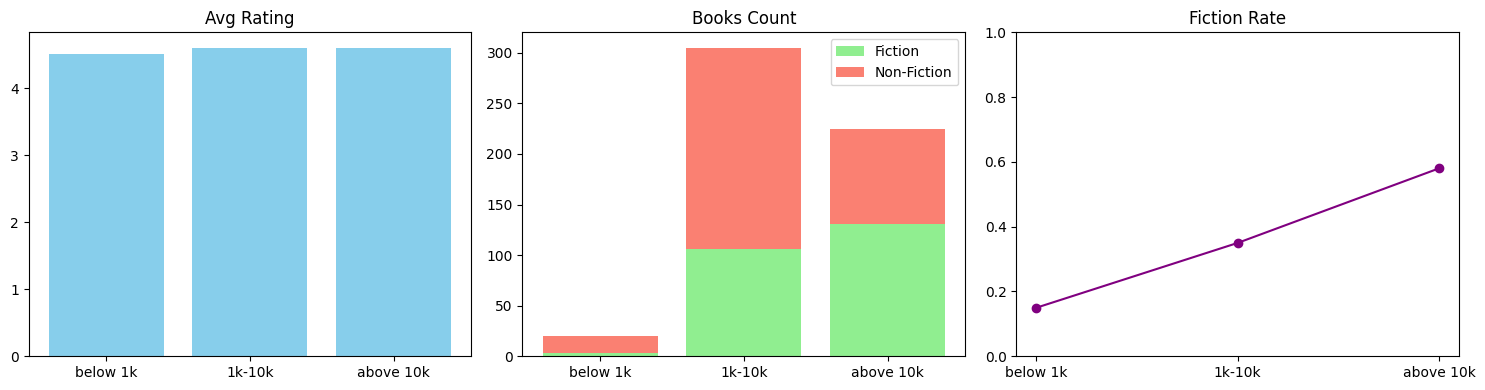

In [61]:
fig, axes = plt.subplots(1, 3, figsize=(15,4))

# Average Rating
axes[0].bar(df['review_bucket'], df['avg_rating'], color='skyblue')
axes[0].set_title('Avg Rating')

# Number of Fiction vs Non-Fiction
axes[1].bar(df['review_bucket'], df['num_fiction'], label='Fiction', color='lightgreen')
axes[1].bar(df['review_bucket'], df['num_non_fiction'], bottom=df['num_fiction'], label='Non-Fiction', color='salmon')
axes[1].set_title('Books Count')
axes[1].legend()

# Fiction Rate
axes[2].plot(df['review_bucket'], df['fiction_rate'], marker='o', color='purple')
axes[2].set_title('Fiction Rate')
axes[2].set_ylim(0,1)

plt.tight_layout()
plt.show()

**- High Ratings Are Common Across All Sales Levels:**
Average ratings remain consistently high (~4.6) across all review buckets, suggesting that most bestsellers are well-rated regardless of total review volume.

**- Higher Reviews ≠ Higher Ratings:**
Books with above 10k reviews do not have higher average ratings than lower-review books. Commercial visibility appears to drive review volume more than rating quality.

**- Fiction Gains Momentum at Scale:**
In the highest review bucket (above 10k), Fiction represents 58%, compared to 15% in the lowest bucket. Fiction titles appear more likely to achieve large-scale commercial traction.

In [41]:
# Is rating more important for Fiction or Non-Fiction?

query = """
select
    genre,
    round(min("User Rating"),1) as min_rating,
    round(avg("User Rating"),1) as avg_rating,
    round(max("User Rating"),1) as max_rating
from amazon_books
group by genre
"""
pd.read_sql_query(query, conn)

,Genre,min_rating,avg_rating,max_rating
0,Fiction,3.3,4.6,4.9
1,Non Fiction,4.0,4.6,4.9


In [47]:
# Are there low-rated books that still sell well?
query = """
select
    "User Rating",
    "Reviews"
from amazon_books
where "User Rating" < 4.0
"""
pd.read_sql_query(query, conn)


,User Rating,Reviews
0,3.9,6310
1,3.8,47265
2,3.8,47265
3,3.6,14982
4,3.3,9372
5,3.9,33844
6,3.9,33844


**- Ratings Are Similar Across Genres:**
Both Fiction and Non-Fiction share the same average rating (4.6). However, Non-Fiction has a slightly higher minimum rating (4.0 vs. 3.3), indicating more rating stability.

**- Low-Rated Books Can Still Sell Well:**
Some books with ratings as low as 3.3–3.8 still accumulate 9k–47k reviews, demonstrating that strong sales can occur even without top-tier ratings.

**=> High ratings are expected among bestsellers but are not a strong differentiator of commercial success. Marketing reach, brand power, and visibility likely play a larger role in driving high review counts.**